# RLCT Estimation of MNIST

This Jupyter Notebook aims to reproduce the results of Lau et al. (2023) by measuring the Real Log Canonical Threshold (RLCT) for a small 2-layer ReLU model (about 1M parameters) trained on the MNIST dataset. It uses both Stochastic Gradient Nose-Hoover Thermostat (SGNHT) and Stochastic Gradient Langevin Dynamics (SGLD) as sampling methods.

## Main Steps:

1. **Data Preparation**: Load the MNIST dataset for training and testing.
2. **Model Training**: Train a multi-layer perceptron model using stochastic gradient descent.
3. **Model Evaluation**: Evaluate the model's performance on a test set.
4. **RLCT Estimation**: Use SGNHT and SGLD samplers to estimate RLCT.
5. **Plotting**: Visualize train and test losses, and RLCT estimates.

In [3]:
import sys 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
sys.path.insert(1, "/home/paperspace/devinterp")  # TODO fix path

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [4]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)

# Define the neural network
class Net(nn.Module):
    def __init__(self, hidden_layer_sizes=[1024, 1024], input_dim=28 * 28, output_dim=10,activation=F.relu, with_bias=True):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

In [5]:
DEVICE = 'cuda'
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_data))
# Load test data
test_data = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize model, loss, optimizer and sgld sampler
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
n_epochs = 20


60000


In [6]:
# train model
train_losses = []
test_losses = []
rlct_estimates = []
models = []
for epoch in range(n_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss = evaluate(model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    # rlct_estimates.append(rlct_estimate)
    models += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")
torch.save(models, 'models.pth')

100%|██████████| 118/118 [00:08<00:00, 13.81it/s]


Epoch 1, Train Loss: 1.4724709684565915, Test Loss: 0.5432195156812668


100%|██████████| 118/118 [00:08<00:00, 14.39it/s]


Epoch 2, Train Loss: 0.42871848657979805, Test Loss: 0.34936231672763823


100%|██████████| 118/118 [00:08<00:00, 14.48it/s]


Epoch 3, Train Loss: 0.33353225735284514, Test Loss: 0.30018110349774363


100%|██████████| 118/118 [00:08<00:00, 14.45it/s]


Epoch 4, Train Loss: 0.2930855609602847, Test Loss: 0.27540634796023367


100%|██████████| 118/118 [00:08<00:00, 14.30it/s]


Epoch 5, Train Loss: 0.26513723612336787, Test Loss: 0.24831788502633573


100%|██████████| 118/118 [00:08<00:00, 14.65it/s]


Epoch 6, Train Loss: 0.24141143009824267, Test Loss: 0.23008266165852548


100%|██████████| 118/118 [00:07<00:00, 14.84it/s]


Epoch 7, Train Loss: 0.22169025810593265, Test Loss: 0.21209274493157865


100%|██████████| 118/118 [00:08<00:00, 14.15it/s]


Epoch 8, Train Loss: 0.20427638153403493, Test Loss: 0.2008304174989462


100%|██████████| 118/118 [00:08<00:00, 14.49it/s]


Epoch 9, Train Loss: 0.18984636405514457, Test Loss: 0.18892620466649532


100%|██████████| 118/118 [00:08<00:00, 14.44it/s]


Epoch 10, Train Loss: 0.1754941356257867, Test Loss: 0.17123146578669549


100%|██████████| 118/118 [00:08<00:00, 14.61it/s]


Epoch 11, Train Loss: 0.16308988668655944, Test Loss: 0.16268023997545242


100%|██████████| 118/118 [00:08<00:00, 14.12it/s]


Epoch 12, Train Loss: 0.1527009774315155, Test Loss: 0.15428304448723792


100%|██████████| 118/118 [00:08<00:00, 14.34it/s]


Epoch 13, Train Loss: 0.14236525319895502, Test Loss: 0.1449959810823202


100%|██████████| 118/118 [00:08<00:00, 13.88it/s]


Epoch 14, Train Loss: 0.13381778221514265, Test Loss: 0.13728714771568776


100%|██████████| 118/118 [00:08<00:00, 14.35it/s]


Epoch 15, Train Loss: 0.12563386126973872, Test Loss: 0.131950369104743


100%|██████████| 118/118 [00:08<00:00, 13.96it/s]


Epoch 16, Train Loss: 0.11808094224434788, Test Loss: 0.12683839667588473


100%|██████████| 118/118 [00:08<00:00, 14.20it/s]


Epoch 17, Train Loss: 0.11130244133331008, Test Loss: 0.11988140698522329


100%|██████████| 118/118 [00:08<00:00, 13.53it/s]


Epoch 18, Train Loss: 0.10476502870856705, Test Loss: 0.11661701463162899


100%|██████████| 118/118 [00:08<00:00, 13.19it/s]


Epoch 19, Train Loss: 0.09966738398928764, Test Loss: 0.1112863240763545


100%|██████████| 118/118 [00:08<00:00, 13.43it/s]


Epoch 20, Train Loss: 0.0935160413195016, Test Loss: 0.1056806101463735


In [8]:
from devinterp.slt.sampler import estimate_rlct
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Load test data
test_data = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize sgnht sampler
# SGNHT_config = SamplerConfig(
#     optimizer_config=dict(
#         optimizer_type="SGNHT",
#         lr=1e-7,
#         diffusion_factor=0.01,
#         # bounding_box_size=0.0001,
#         num_samples=len(train_data),
#         batch_size = batch_size
#     ),
#     num_chains=1,
#     num_draws_per_chain=400,
#     num_burnin_steps=0,
#     num_steps_bw_draws=1,
#     verbose=False,
#     batch_size=batch_size,         
#     criterion = 'cross_entropy' # alternatives: mse
# )
# SGLD_config = SamplerConfig(
#     optimizer_config=dict(
#         optimizer_type="SGLD",
#         lr=1e-5,
#         noise_level=1.,
#         # weight_decay = 0.01,
#         elasticity=100.,
#         temperature='adaptive',
#         num_samples=len(train_data),
#     ),
#     num_chains=1,
#     num_draws_per_chain=400,
#     num_burnin_steps=0,
#     num_steps_bw_draws=1,
#     verbose=False,
#     batch_size=batch_size,         
#     criterion = 'cross_entropy' # alternatives: mse
# )

models = torch.load('models.pth')
rlct_estimates_sgnht = []
rlct_estimates_sgdl = []
for n in range(n_epochs):
    rlct_estimate_sgnht = estimate_rlct(
            model,
            train_loader,
            criterion=criterion,
            optimizer_kwargs=dict(
                lr=lr,
                diffusion_factor=0.01,
                bounding_box_size=1.0,
                num_samples=len(train_data),
                batch_size=batch_size,
            ),
            sampling_method=SGNHT,
            num_chains=1,
            num_draws=1_000,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
        )
    rlct_estimate_sgdl = estimate_rlct(
            model,
            train_loader,
            criterion=criterion,
            optimizer_kwargs=dict(
                lr=lr,
                bounding_box_size=1.0,
                num_samples=len(train_data),
            ),
            sampling_method=SGLD,
            num_chains=1,
            num_draws=1_000,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
        )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgdl += [rlct_estimate_sgdl]
plt.hist(rlct_estimates_sgnht,alpha = 0.5, label='sgnht')
plt.hist(rlct_estimates_sgdl,alpha = 0.5, label='sgdl')
plt.legend()
plt.show()
# Plotting


Chain 0:  40%|████      | 401/1000 [01:45<02:37,  3.79it/s]


KeyboardInterrupt: 

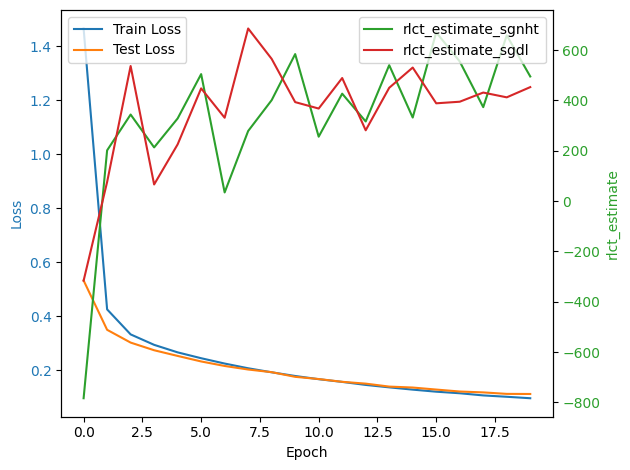

In [ ]:
import numpy as np
np.save('rlct_estimates_sgdl.npy', rlct_estimates_sgdl)
np.save('rlct_estimates_sgnht.npy', rlct_estimates_sgnht)
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(train_losses, label='Train Loss', color='tab:blue')
ax1.plot(test_losses, label='Test Loss', color='tab:orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx() 
ax2.set_ylabel('rlct_estimate', color='tab:green')
ax2.plot(rlct_estimates_sgnht, label='rlct_estimate_sgnht', color='tab:green')
ax2.plot(rlct_estimates_sgdl, label='rlct_estimate_sgdl', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()